In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
tqdm.pandas()

> 이 코드는 facenet_abouttime의 threshold를 구함

deepface로 거리구하는 부분 너무 오래걸리니까<br>
다시 돌려보고 싶으면<br>
`df1 = pd.read_csv('/content/drive/MyDrive/기업프로젝트-라젠/deepface/tests/outputs/pair_with_dist_Asian_6000_non_cropped_facenet_abouttime.csv')`로
파일 불러다가 쓰세요

# 1. 동양인 데이터
- 같은 사람 3000 pairs, 다른 사람 3000 pairs

In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/기업프로젝트-라젠/deepface/tests/pair_with_dist_l2.csv')
del df1['distance'], df1['distance_l2']
df1

,file_x,file_y,decision
0,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
1,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
2,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
3,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
4,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
...,...,...,...
5995,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
5996,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
5997,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
5998,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No


In [ ]:
import os
os.getcwd()
os.chdir("/content/drive/My Drive/기업프로젝트-라젠/deepface/")

In [ ]:
!pip install mtcnn
from deepface import DeepFace

     |████████████████████████████████| 2.3MB 13.2MB/s 
Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

instances = df1[["file_x", "file_y"]].values.tolist()
model_name = "facenet_abouttime"
distance_metric = "euclidean_l2"
resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric, enforce_detection=False)

Using facenet_abouttime model backend and euclidean_l2 distance.


Verification: 100%|██████████| 6000/6000 [47:33<00:00,  2.10it/s]


In [ ]:
distances = []
for i in range(0, len(instances)):
    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
    distances.append(distance)

In [ ]:
df1["distance_l2"] = distances

In [ ]:
df1['distance_l2_scaled'] = -df1['distance_l2']

---
데이터 가져와서 쓸 땐 여기부터 돌리기

In [ ]:
# df1 = pd.read_csv('/content/drive/MyDrive/기업프로젝트-라젠/deepface/tests/outputs/pair_with_dist_Asian_6000_non_cropped_facenet_abouttime.csv')

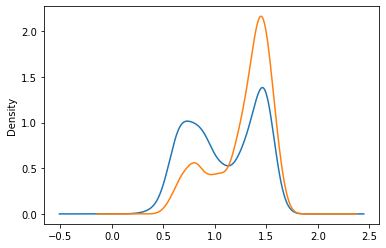

In [6]:
df1[df1.decision == "Yes"].distance_l2.plot.kde()
df1[df1.decision == "No"].distance_l2.plot.kde()

In [8]:
df1

,file_x,file_y,decision,distance_l2,distance_l2_scaled
0,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,1.5620,-1.5620
1,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.6969,-0.6969
2,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,1.4190,-1.4190
3,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,1.4395,-1.4395
4,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,1.2381,-1.2381
...,...,...,...,...,...
5995,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.2164,-1.2164
5996,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,0.7844,-0.7844
5997,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.3908,-1.3908
5998,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.1231,-1.1231


In [ ]:
# df1.to_csv('/content/drive/My Drive/기업프로젝트-라젠/deepface/tests/outputs/pair_with_dist_Asian_6000_non_cropped_facenet_abouttime.csv', index=False)

# ROC curve

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

In [11]:
encoder = LabelEncoder()
encoder.fit(df1['decision'])
df1['y'] = encoder.transform(df1['decision']) # 1='Yes' / 0='No'
fpr, tpr, thresholds = roc_curve(df1['y'], df1['distance_l2_scaled'], pos_label=1)
roc_auc = auc(fpr, tpr)

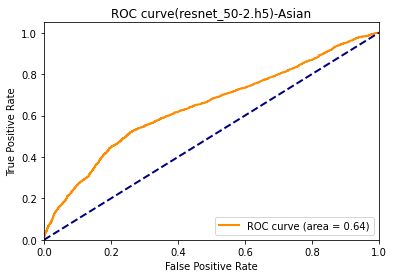

In [12]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve(resnet_50-2.h5)-Asian')
plt.legend(loc="lower right")
plt.show()

# threshold
- not using k-fold

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import graphviz
from sklearn.tree import export_graphviz

In [16]:
clf1 = DecisionTreeClassifier(max_depth=1)
X = np.array(df1['distance_l2']).reshape(-1, 1)
y = np.array(df1['y']).reshape(-1, 1)
clf1.fit(X, y)
print("Accuracy: {}%".format(clf1.score(X, y) * 100))

Accuracy: 63.1%


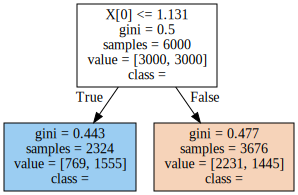

In [17]:
export_graphviz(clf1, out_file='clf1.dot', class_names=['불일치', '일치'], impurity=True, filled=True)
with open('clf1.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [18]:
threshold = clf1.tree_.threshold[0]
print('Asian threshold for facenet_abouttime (6000 non-cropped data) = {}'.format(threshold))

Asian threshold for facenet_abouttime (6000 non-cropped data) = 1.130649983882904


In [19]:
df1["pred_euclidean_l2"] = "No"

idx = df1[df1.distance_l2 <= threshold].index
df1.loc[idx, 'pred_euclidean_l2'] = 'Yes'

In [20]:
cm = confusion_matrix(df1.decision.values, df1.pred_euclidean_l2.values)
cm

array([[2231,  769],
       [1445, 1555]])

In [21]:
tn, fp, fn, tp = cm.ravel()
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

In [22]:
print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  66.91049913941481 %
Recall:  51.83333333333333 %
F1 score  58.41472577009766 %
Accuracy:  63.1 %


---

# 2. lfw 데이터

In [ ]:
df2 = pd.read_csv('/content/drive/My Drive/기업프로젝트-라젠/deepface/tests/pair_with_dist_lfw.csv')
del df2['distance_l2']
df2

,file_x,file_y,decision
0,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes
1,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes
2,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes
3,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes
4,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes
...,...,...,...
5995,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No
5996,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No
5997,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No
5998,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No


In [ ]:
df2.iloc[0,0]
# /content/drive/My Drive/main_proj/라젠/deepface/tests/lfw_funneled_samples/ 
# -> /content/drive/My Drive/기업프로젝트-라젠/deepface/tests/lfw_funneled_samples/

'/content/drive/My Drive/main_proj/라젠/deepface/tests/lfw_funneled_samples/Ariel_Sharon/Ariel_Sharon_0075.jpg'

In [ ]:
a = '/content/drive/My Drive/main_proj/라젠/deepface/tests/lfw_funneled_samples/'
b = '/content/drive/My Drive/기업프로젝트-라젠/deepface/tests/lfw_funneled_samples/'

df2['file_x'] = df2['file_x'].apply(lambda x: x.replace(a, b))
df2['file_y'] = df2['file_y'].apply(lambda x: x.replace(a, b))

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

instances = df2[["file_x", "file_y"]].values.tolist()
model_name = "facenet_abouttime"
distance_metric = "euclidean_l2"
resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric, enforce_detection=False)
# 1시간 걸림(6000 pairs)

Using facenet_abouttime model backend and euclidean_l2 distance.


Streaming output truncated to the last 5000 lines.
Verification: 100%|██████████| 6000/6000 [29:51<00:00,  3.35it/s]


In [ ]:
distances = []
for i in range(0, len(instances)):
    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
    distances.append(distance)
df2["distance_l2"] = distances

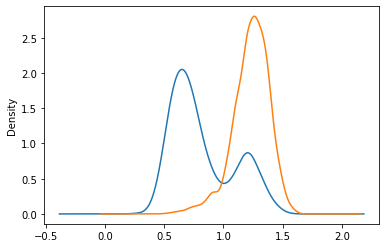

In [ ]:
df2[df2.decision == "Yes"].distance_l2.plot.kde()
df2[df2.decision == "No"].distance_l2.plot.kde()

In [ ]:
# df2.to_csv('pair_with_dist_lfw_6000_non_cropped_facenet_abouttime.csv', index=False)

# ROC curve

In [ ]:
df2['distance_l2_scaled'] = -df2['distance_l2']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df2['decision'])
df2['y'] = encoder.transform(df2['decision']) # 1='Yes' / 0='No'
df2['y']

0       1
1       1
2       1
3       1
4       1
       ..
5995    0
5996    0
5997    0
5998    0
5999    0
Name: y, Length: 6000, dtype: int64

In [ ]:
fpr, tpr, thresholds = roc_curve(df2['y'], df2['distance_l2_scaled'], pos_label=1)
roc_auc = auc(fpr, tpr)

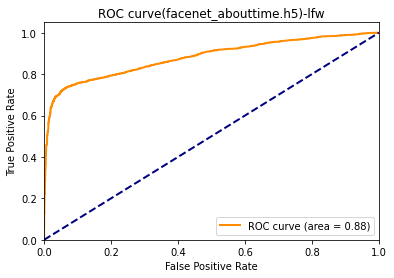

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve(facenet_abouttime.h5)-lfw')
plt.legend(loc="lower right")
plt.show()

# Threshold

In [ ]:
clf2 = DecisionTreeClassifier(max_depth=1)
X = np.array(df2['distance_l2']).reshape(-1, 1)
y = np.array(df2['y']).reshape(-1, 1)
clf2.fit(X, y)
print(clf2.score(X, y))

0.8343333333333334


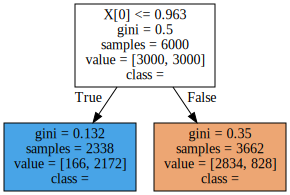

In [ ]:
export_graphviz(clf2, out_file='clf2.dot', class_names=['불일치', '일치'], impurity=True, filled=True)
with open('clf2.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [ ]:
threshold = clf2.tree_.threshold[0]

In [ ]:
df2["pred_euclidean_l2"] = "No"

idx = df2[df2.distance_l2 <= threshold].index
df2.loc[idx, 'pred_euclidean_l2'] = 'Yes'

In [ ]:
df2.sample(5)

,file_x,file_y,decision,distance_l2,distance_l2_scaled,y,pred_euclidean_l2
5165,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.1231,-1.1231,0,No
863,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.4810,-0.4810,1,Yes
4502,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.4514,-1.4514,0,No
4397,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.3373,-1.3373,0,No
2011,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.6118,-0.6118,1,Yes


In [ ]:
cm = confusion_matrix(df2.decision.values, df2.pred_euclidean_l2.values)
cm

array([[2834,  166],
       [ 828, 2172]])

In [ ]:
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp 

(2834, 166, 828, 2172)

In [ ]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  92.89991445680069 %
Recall:  72.39999999999999 %
F1 score  81.37879355563882 %
Accuracy:  83.43333333333334 %
